In [55]:
import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred

"""For this assessment I decided to use an API called FRED to pull the monthly Par Yield rates from the department of Treasury."""

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Create Fred object with the secrete key from config file
fred = Fred(api_key= config.api_key)

# Search the FRED API for data
search_data = fred.search('Market Yield on U.S. Treasury Securities')
#print(search_data['title'])

# Pull raw data and plot
start_date = '1/1/2020'
end_date = '1/30/2020'

s_1yr = fred.get_series('GS1', observation_start = start_date, observation_end = end_date)
s_2yr = fred.get_series('GS2', observation_start = start_date, observation_end = end_date)
s_5yr = fred.get_series('GS5', observation_start = start_date, observation_end = end_date)
s_10yr = fred.get_series('GS10', observation_start = start_date, observation_end = end_date)
s_20yr = fred.get_series('GS20', observation_start = start_date, observation_end = end_date)
s_30yr = fred.get_series('GS30', observation_start = start_date, observation_end = end_date)

# Dataframe of Par Yield rates at different maturities
df_paryield = pd.concat([s_1yr, s_2yr, s_5yr, s_10yr, s_20yr, s_30yr], keys=[12,24,60,120,240,360], axis=1)
df_paryield

,12,24,60,120,240,360
2020-01-01,1.53,1.52,1.56,1.76,2.07,2.22


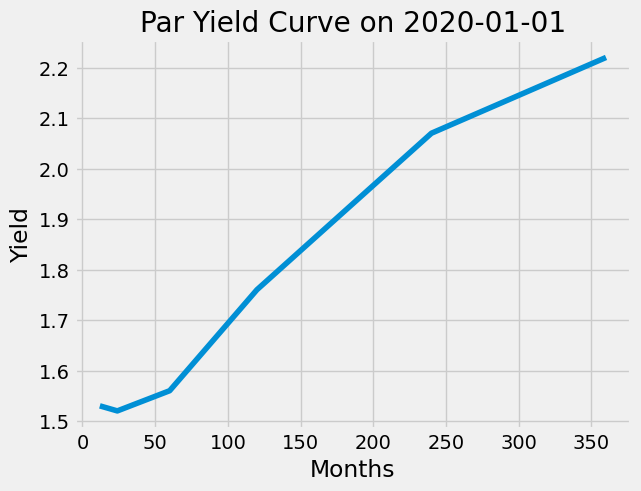

In [56]:
# This function returns a plot the Par Yield data alone given a dataframe of Par Yield rates
def plot_paryield_of_dataframe(df, row_date):
    # Convert the row_date to a datetime object
    row_date = pd.to_datetime(row_date)

    # Get the row corresponding to the given date
    row = df.loc[row_date]

    # Plot the row
    plt.plot(row.index, row.values)
    plt.xlabel('Months')
    plt.ylabel('Yield')
    plt.title(f"Par Yield Curve on {row_date.strftime('%Y-%m-%d')}")
    plt.show()
    
plot_paryield_of_dataframe(df_paryield, "2020-01-01")

In [67]:

# This function returns a dataframe of zero rates using the bootstrap method for a give dataframe of par yield rates using the bootstrap method
def bootstrap(par_yield_rates_df):
    par_yield_rates_df = par_yield_rates_df / 100
    num_periods = len(par_yield_rates_df.columns)
    years = df_paryield.columns/12
    
    # Define an empty DataFrame to store zero rates
    zero_df = pd.DataFrame(index=par_yield_rates_df.index, columns=par_yield_rates_df.columns)
    
    # Make values of the first column of zero rate DataFrame equal to par yield
    zero_df.iloc[:,0] = par_yield_rates_df.iloc[:,0]
    
    # Iterate each row
    for row in range(len(zero_df)):
        # Iterate through each element
        for i in range(1, num_periods):
            
            par_rate_current = par_yield_rates_df.iloc[row, i]
            #print('This is the current par rate:',par_rate_current)
            
            previous_zero_rate = zero_df.iloc[row,i-1]
            #print('This is the previous zero rate',previous_zero_rate)
            
            c = 1 + par_rate_current
            #print('This is the new c ',c)
            
            # This is where I bootstrapped out to 30 years to calculate the zero rate at 24 months
            if i == 1:
                b = par_rate_current/((1 + previous_zero_rate) ** years[-1])
                denom = (1 + previous_zero_rate) ** years[-1]
                bootstrap_value = 1 - (par_rate_current * (1/denom))
                # Simplified formula for Zero rates: a = (c/((bootstrap)**(1/current_YTM))) - 1
                a = ((c/bootstrap_value) ** (1/years[i])) - 1
            
            # The zero rate calculated via bootstrap carries into all years after 24 months
            else:
                b = par_rate_current/((1 + previous_zero_rate) ** years[i-1])
                # Simplified formula for Zero rates: a = (c/((1-b)**(1/previous_YTM))) - 1
                a = ((c / ((1 - b) ** (1/years[i]))) - 1)

            # Add calculated zero rate to dataframe
            zero_df.iloc[row, i] = a
    
    zero_df = zero_df * 100
    return zero_df

zero_rates = bootstrap(df_paryield)
zero_rates

,12,24,60,120,240,360
2020-01-01,1.53,1.246249,1.871969,1.924693,2.158099,2.269726


In [58]:

# This function returns the discount factor and the natural log for a given dataframe of zero-rates
def discount_factor(zero_rates_df):
    discount_factor = []
    ln_discount_factor = []
    
    # Iterate each row
    for row in range(len(zero_rates_df)):
        # Iterate through each element
        for i in range(len(zero_rates_df.columns)):
            zero_rate_current = zero_rates_df.iloc[row, i]
            #print('This is the current zero rate:',zero_rate_current)
            
            discount_factor_current = 1/((1 + (zero_rate_current/100)) ** zero_rates.columns[i])
            ln_discount_factor.append(np.log(discount_factor_current))
            discount_factor.append(discount_factor_current)
            #print(f'The discount factor is {discount_factor_current} and the months are {df_paryield.columns[i]}')
    
    return discount_factor, ln_discount_factor

discnt_factor = discount_factor(zero_rates)[0]
log_DF = discount_factor(zero_rates)[1]


In [62]:

# Create dictionary of data to place in dataframe
data = {'Time-Point': zero_rates.columns, 'Par Yield':df_paryield.iloc[0,:],'Zero-rate (Annual)':((1 + (zero_rates.iloc[0,:]/100))**12),'Zero-rate (Mo.)':zero_rates.iloc[0,:], 'DF':discnt_factor, 'Log(DF)':log_DF }

# Create dataframe out of data
df = pd.DataFrame(data)

# Create a new DataFrame with the desired index
new_index = range(12, 361)  # New index values between 12 and 360 (inclusive) in steps of 12
new_df = pd.DataFrame(index=new_index)

# Interpolate to fill in the new index with values for months in between maturities
interpolated_df = df.interpolate(method='linear').reindex(new_df.index)

# Combine the interpolated values with the original DataFrame (excluding the existing rows)
final_df = pd.concat([df[~df.index.isin(new_df.index)], interpolated_df]).sort_index()

# Linear interpolation of the log of the discount factors to find the missing values (months in between maturities)
final_df['Log(DF)'] = final_df['Log(DF)'].interpolate(method='linear')

# Interpolation of the Time-Point in order to fill in missing values
final_df['Time-Point'] = final_df['Time-Point'].interpolate(method='linear')

# Work backwards to find values for DF, Zero-rate(Mo) and Zero-rate(Annual)
final_df['DF'] = np.exp(final_df['Log(DF)'])
final_df['Zero-rate (Mo.)'] = (((1/final_df['DF'])**(1/final_df['Time-Point'])) - 1)
final_df['Zero-rate (Annual)'] = (1 + final_df['Zero-rate (Mo.)'])**12

# Convert to percent
final_df['Zero-rate (Mo.)'] = final_df['Zero-rate (Mo.)'] * 100

print("Final Interpolated Table:")
final_df

#df.reset_index(drop=True)

Final Interpolated Table:


,Time-Point,Par Yield,Zero-rate (Annual),Zero-rate (Mo.),DF,Log(DF)
12,12.0,1.53,1.199866,1.530000,0.833427,-0.182210
13,13.0,NaN,1.193682,1.486294,0.825475,-0.191796
14,14.0,NaN,1.188408,1.448847,0.817599,-0.201383
15,15.0,NaN,1.183855,1.416404,0.809798,-0.210970
16,16.0,NaN,1.179886,1.388025,0.802072,-0.220557
...,...,...,...,...,...,...
356,356.0,NaN,1.308691,2.267216,0.000342,-7.981152
357,357.0,NaN,1.308788,2.267849,0.000334,-8.005780
358,358.0,NaN,1.308885,2.268478,0.000325,-8.030407
359,359.0,NaN,1.308981,2.269104,0.000317,-8.055035


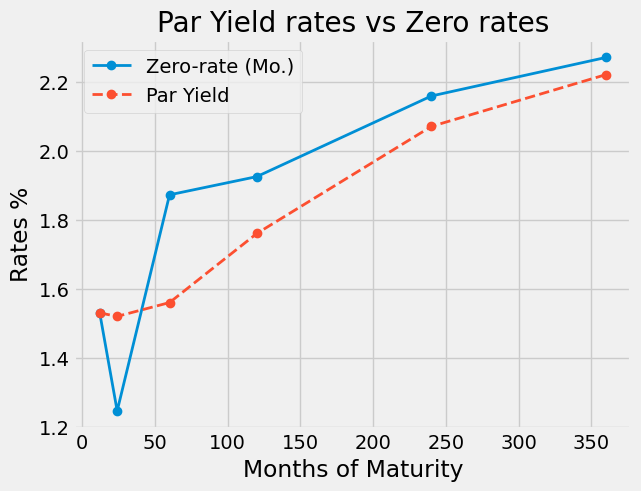

In [60]:
line_1 = 'Zero-rate (Mo.)'
line_2 = 'Par Yield'

df['Zero-rate (Mo.)'].plot(marker='o', lw=2)
df['Par Yield'].plot(marker='o',linestyle='--', lw=2)

plt.title('Par Yield rates vs Zero rates')
plt.xlabel('Months of Maturity')
plt.ylabel('Rates %')

# Legend for the data
plt.legend([line_1, line_2])

# Plot of both the Par Yield rates and the calculated Zero Rates from interpolated table
plt.show()